## Задание

## Классификатор акустических событий

### Задача:

* Реализовать классификатор, работающий на представленных акустических событиях. https://drive.google.com/open?id=1_UQRTDw_lQfF6e6QoqojGrG1J5Rzpxee

* Проверки результатов производится на папке test (данные из этой папки нельзя использовать для обучения!)

* Необходимо результаты представить в виде текстового файла содержащего имя файла, score, класс события. Пример файла лежит вместе с базой: result.txt.

* Код выложить на github, и прислать соответствующую ссылку.

* Дополнительные улучшения, которые обеспечат более высокую оценку:
 * Решение не только закрытой но и открытой задачи. (в валедирующем тестсете присутствуют файлы с неизвестными событиями, результаты по открытой и закрытой задаче оцениваются отдельно).
 * Детектор наличия факта события (добавляется как предварительная обработка сигнала перед тем как отправлять его на классификатор). Определяет время начала и окончания события.


### Входные данные:

* База акустических событий data_v_7_stc.7z  Содержит 3 подкаталога.

* В каталоге ./audio. находятся wav файлы(PCM;16000hz;mono).

* Файл ./meta/meta.txt содержит метки  класса акустического шума. Всего в базе присутствует 8 типов акустических шумов: background, bags, door, keyboard, knocking_door, ring, speech, tool.
* В каталоге test находятся wav файлы валидирующего тестсета.

### Выходные данные:

* программа (желательно на питоне).
* result.txt Результат обработки классификатором валедирующего тестсета из папки test. Формат результата описан выше, пример в архиве с базой.

### Критерий успеха:
* Получен хороший скор для закрытой и для открытой задачи.
* В ходе ревью кода будет предпринята попытка повторить результат, и основной критерий, что это получиться сделать! Соответственно к коду должна прикладываться краткая инструкция (что надо сделать с данными, установкой фрэймворков или ещё чем то, чтобы получить с помощью Вашего кода обещанный результат). Одна из целей воспроизведения - проверка на отсутствие использования валедирующего тестсета из папки test для обучения алгоритма, поэтому при желании использовать дополнительные данные из интернета убедитесь, что они не входят в test или свяжитесь с нами, мы поможем проверить, что этих данных нет в валидирующем тестсете.

In [1]:
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
RND=42

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
meta = pd.read_csv('meta.txt', sep='\t', header=None) 

In [3]:
meta.columns = ['f_name','scene','start','end','label']

In [4]:
meta.head()

f_name   scene  start        end       label
0                  background_0001.wav  office      0   9.458500  background
1   background_0001_time_stretch_0.wav  office      0   9.989070  background
2   background_0001_time_stretch_1.wav  office      0   9.879410  background
3  background_0001_time_stretch_10.wav  office      0  11.156553  background
4  background_0001_time_stretch_11.wav  office      0  13.261587  background

In [5]:
meta.label.value_counts()

door             3416
tool             1659
knocking_door    1656
bags             1236
keyboard         1225
background       1126
ring              713
speech            276
Name: label, dtype: int64

In [6]:
meta.scene.value_counts()

office    11307
Name: scene, dtype: int64

In [7]:
meta.start.value_counts()

0    11307
Name: start, dtype: int64

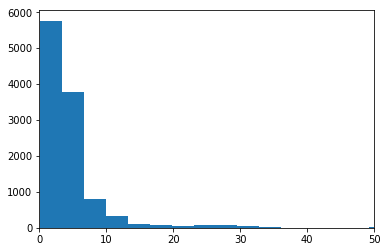

In [25]:
plt.hist(meta.end, bins=100)
plt.xlim(0,50)
plt.show()

Useless features "scene" and "start":

In [9]:
meta.drop(['scene','start'], axis=1, inplace=True)

In [10]:
ratio = []
for c in meta.label.value_counts():
    ratio.append(int(1000 * (c / meta.shape[0])))
    
len_pick = list(zip(meta.label.value_counts().keys(), ratio))

idx = []
for label, n in len_pick:
    idx.extend(meta[meta.label==label].sample(n=n, random_state=RND).index)
    
meta_sample = meta.iloc[idx]

In [12]:
import librosa.display

def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X, sr = librosa.load('audio/' + fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(20,40))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(8,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(20,40))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(8,1,i)
        plt.specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names, raw_sounds):
    i = 1
    fig = plt.figure(figsize=(20,40))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(8,1,i)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(f))**2)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def wav_to_l_spec(raw_sounds):
    specs = []
    for s in raw_sounds:
        d = librosa.amplitude_to_db(np.abs(librosa.stft(s))**2)
        specs.append(d)
    return specs

In [13]:
SPECS = wav_to_l_spec(load_sound_files(meta_sample.f_name))

In [14]:
sound_file_paths = ['bags_0001.wav', 'door_0007.wav', 'ring_0001.wav', 'knocking_door_0053.wav', 'speech_0016.wav', 'tool_1640.wav',
                   'keyboard_0043.wav', 'background_0001.wav']

In [15]:
sound_names = ['bags','door','ring', 'knocking_door', 'speech', 'tool', 'keyboard', 'background']

In [16]:
raw_sounds = load_sound_files(sound_file_paths)

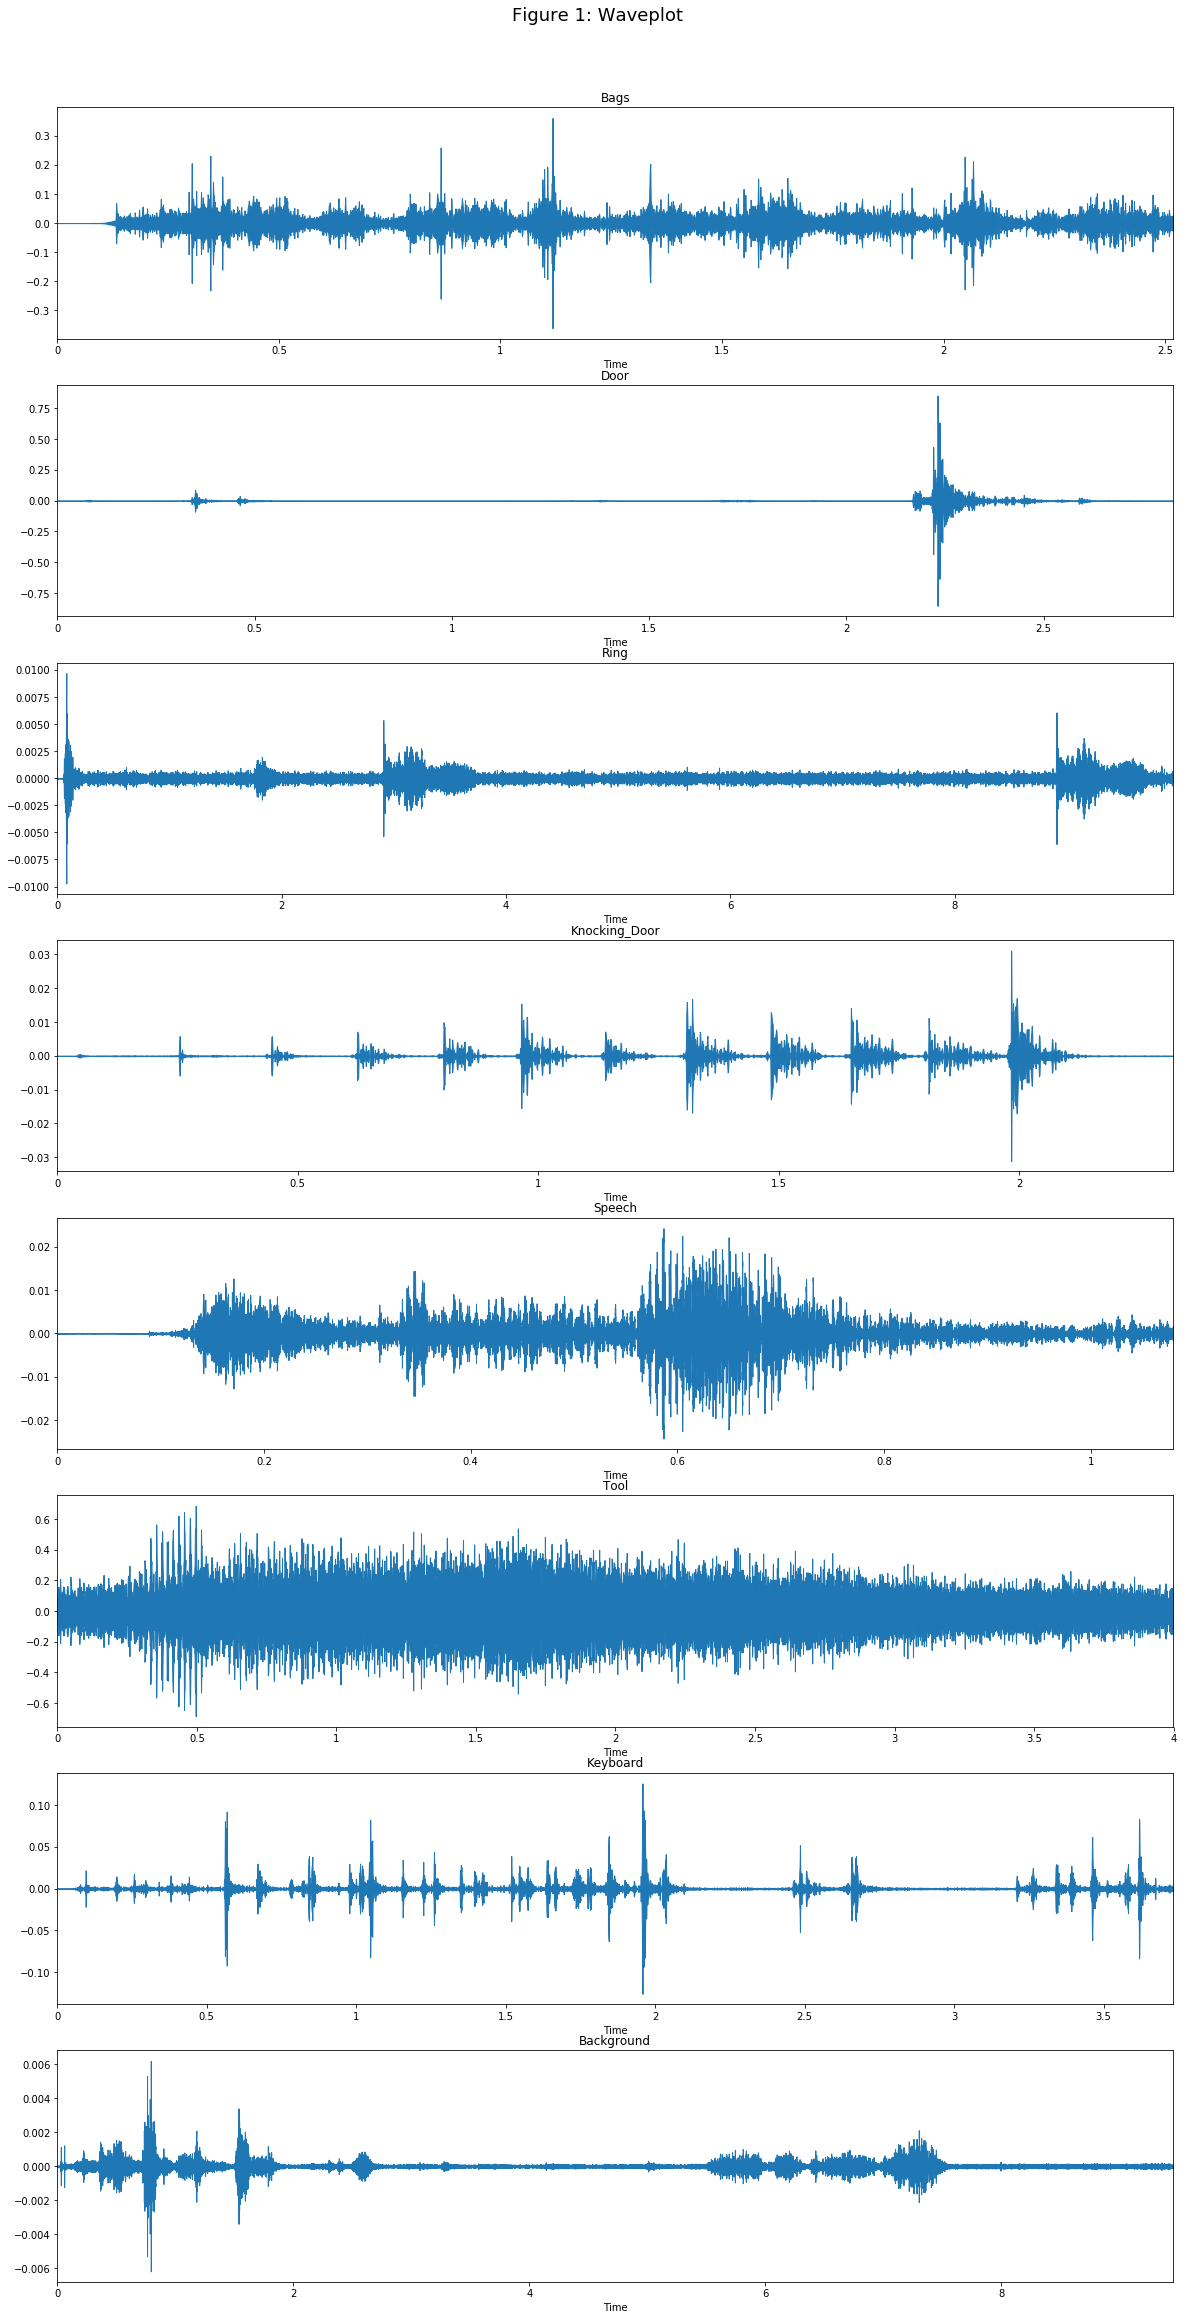

In [17]:
plot_waves(sound_names,raw_sounds)

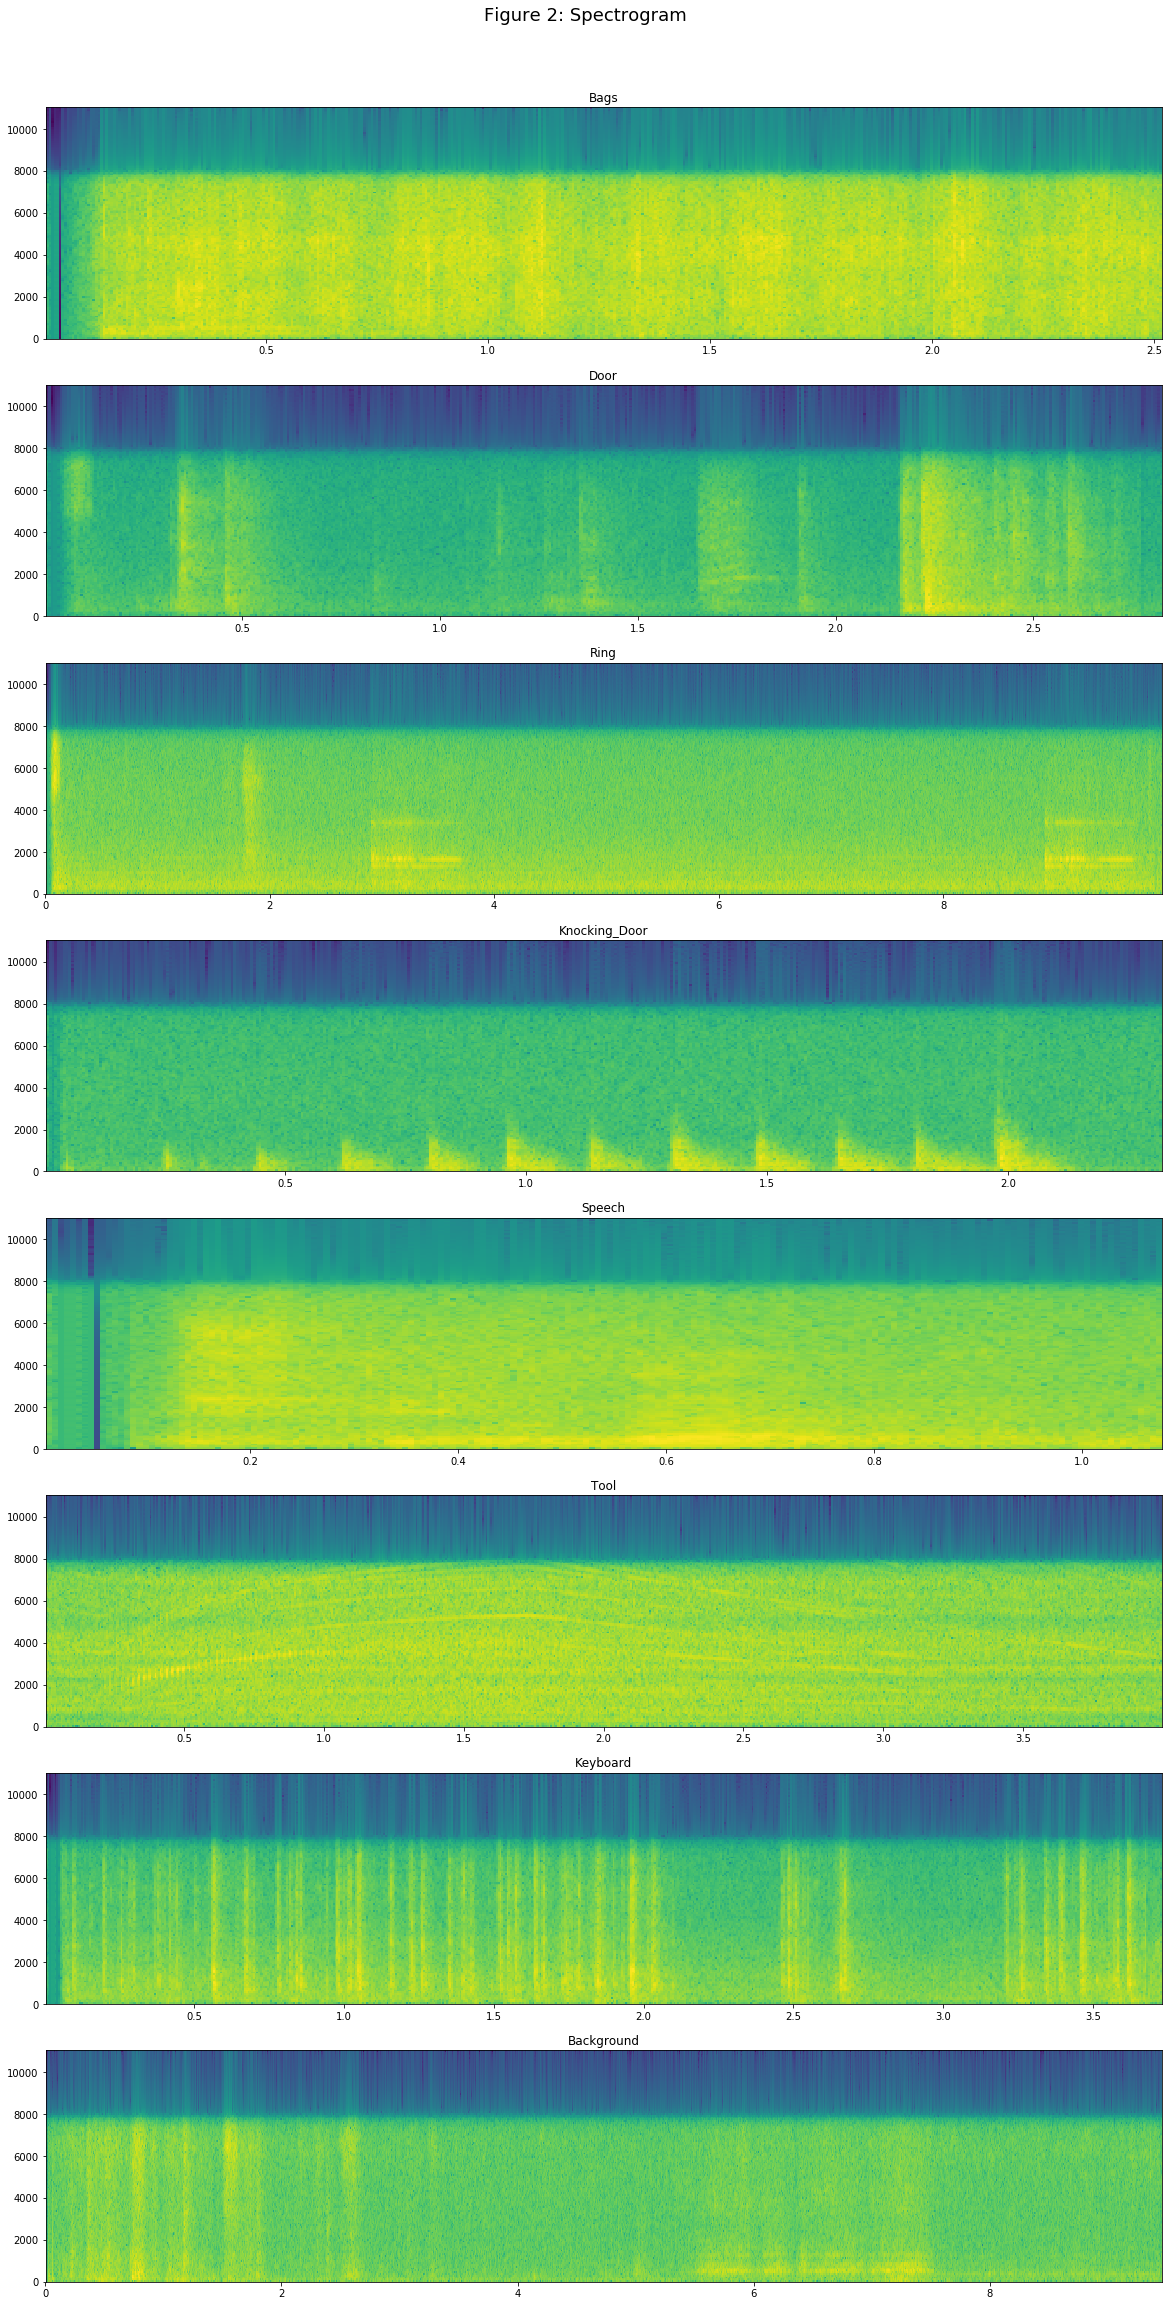

In [18]:
plot_specgram(sound_names,raw_sounds)

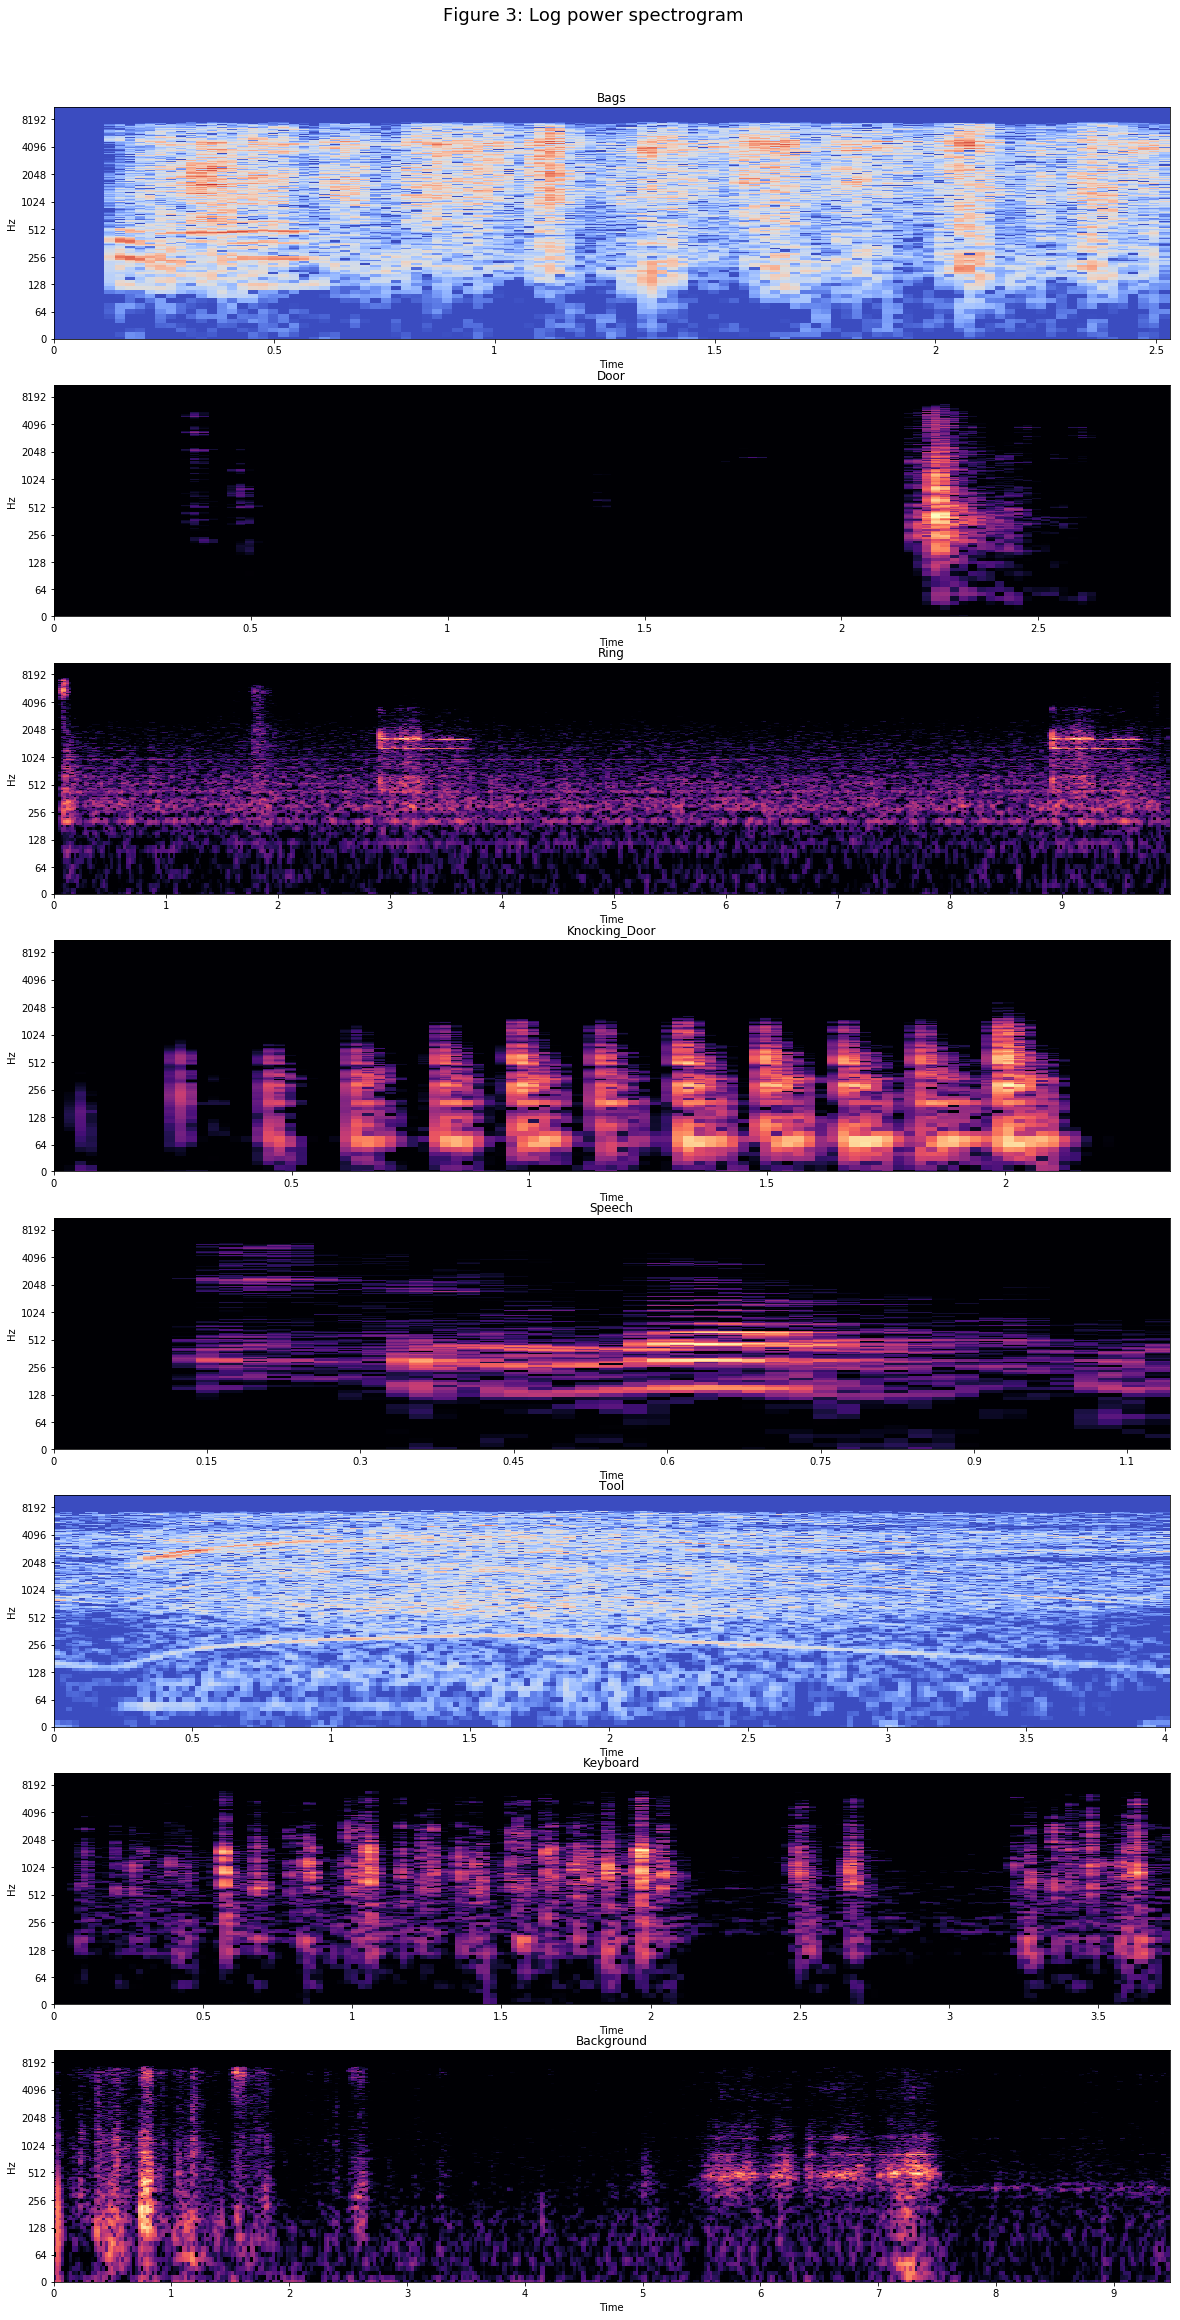

In [19]:
plot_log_power_specgram(sound_names,raw_sounds)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(SPECS, meta_sample.label, test_size = 0.3)

In [21]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def one_hot_encode(labels):
    return OneHotEncoder(sparse=False).fit_transform((LabelEncoder().fit_transform(labels)).reshape(len(labels), 1))

In [22]:
y_train, y_test = one_hot_encode(y_train), one_hot_encode(y_test)

In [42]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

ValueError: could not broadcast input array from shape (1025,478) into shape (1025)

In [10]:
def extract_feature(file_name):
    X, sample_rate = librosa.load('audio/' + file_name)
    stft = np.abs(librosa.stft(X)) # short-time Fourier transform
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) # mel-frequency cepstral coefficients
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0) # chromagram from a waveform
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0) # mel-scaled spectrogram
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0) # spectral contrast 
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0) # tonal centroid features
    return mfccs, chroma, mel, contrast, tonnetz

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode
    
'''
tr_features, tr_labels = 
ts_features, ts_labels = 

tr_labels = one_hot_encode(tr_labels)
ts_labels = one_hot_encode(ts_labels)


training_epochs = 50
n_dim = tr_features.shape[1]
n_classes = 10
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], 
mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:tr_features,Y:tr_labels})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: ts_features})
    y_true = sess.run(tf.argmax(ts_labels,1))
    print("Test accuracy: ",round(session.run(accuracy, feed_dict={X: ts_features,Y: ts_labels}),3))

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average="micro")
print("F-Score:", round(f,3))'''

'\ntr_features, tr_labels = \nts_features, ts_labels = \n\ntr_labels = one_hot_encode(tr_labels)\nts_labels = one_hot_encode(ts_labels)\n\n\ntraining_epochs = 50\nn_dim = tr_features.shape[1]\nn_classes = 10\nn_hidden_units_one = 280 \nn_hidden_units_two = 300\nsd = 1 / np.sqrt(n_dim)\nlearning_rate = 0.01\n\nX = tf.placeholder(tf.float32,[None,n_dim])\nY = tf.placeholder(tf.float32,[None,n_classes])\n\nW_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))\nb_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))\nh_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)\n\nW_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], \nmean = 0, stddev=sd))\nb_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))\nh_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)\n\nW = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))\nb = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd

In [11]:
mfccs_l = []
chroma_l = [] 
mel_l = [] 
contrast_l = [] 
tonnetz_l = []

In [ ]:
for i in range(meta.shape[0])[100:]:
    fn = meta.iloc[i].f_name
    mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
    mfccs_l.append(mfccs)
    chroma_l.append(chroma)
    mel_l.append(mel)
    contrast_l.append(contrast)
    tonnetz_l.append(tonnetz)

C:\Users\user\Anaconda3\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [ ]:
meta['mfccs'] = mfccs_l
meta['chroma'] = chroma_l
meta['mel'] = mel_l
meta['contrast'] = contrast_l
meta['tonnetz'] = tonnetz_l

In [ ]:
labels = meta.label
features = meta[['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz']]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(SPECS, meta.label, test_size=0.33, random_state=42)

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

In [ ]:
def extract_feature(file_name):
    X, sample_rate = librosa.load('audio/' + file_name)
    stft = np.abs(librosa.stft(X)) # short-time Fourier transform
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) # mel-frequency cepstral coefficients
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0) # chromagram from a waveform
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0) # mel-scaled spectrogram
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0) # spectral contrast 
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0) # tonal centroid features
    return mfccs, chroma, mel, contrast, tonnetz

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [5]:
import os, re
validate = os.listdir('test/')
val_label = []

for filename in validate:
    val_label.append(re.split('_', filename)[0])

In [7]:

for filename in validate:
    val_label.append(re.split('_', filename)[0])

In [9]:
open_id = val_label.index('unknown')

473

overlap= 16000
framesize= 32000
number of frames are = 3


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ComplexWarning: Casting complex values to real discards the imaginary part


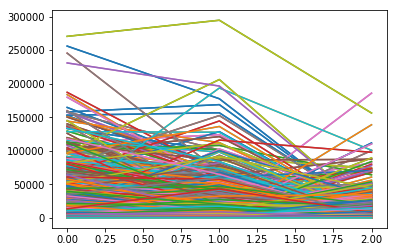

In [127]:
import numpy
import matplotlib.pyplot as plt
import scipy.io.wavfile   #This library is used for reading the .wav file
[fs,signal]=scipy.io.wavfile.read('audio/keyboard_0043.wav') #input wav file ,change here
# fs=sampling frequency,signal is the numpy 2D array where the data of the wav file is written
length=len(signal) # the length of the wav file.This gives the number of samples ,not the length in time
window_hop_length=1 #10ms change here
overlap=int(fs*window_hop_length)
print('overlap=' ,overlap)
window_size=2 #25 ms,change here
framesize=int(window_size*fs)
print('framesize=',framesize)
number_of_frames = int(length/overlap);
nfft_length=framesize #length of DFT ,change here
print('number of frames are =',number_of_frames)
frames=numpy.ndarray((int(number_of_frames),framesize)) # This declares a 2D matrix,with rows equal to the number of frames,and columns equal to the framesize or the length of each DTF
for k in range(0,int(number_of_frames)):
      for i in range(0,framesize):
            if ((k*overlap+i) < length):
                frames[k][i] = signal[k*overlap+i]
            else:
                frames[k][i] = 0
fft_matrix = numpy.ndarray((number_of_frames,framesize)) #declares another 2d matrix to store  the DFT of each windowed frame
abs_fft_matrix=numpy.ndarray((number_of_frames,framesize)) #declares another 2D Matrix to store the power spectrum
for k in range(0,number_of_frames):
    fft_matrix[k]=numpy.fft.fft(frames[k]) #computes the DFT
    abs_fft_matrix[k]=abs(fft_matrix[k])*abs(fft_matrix[k])/(max(abs(fft_matrix[k]))) # computes the power spectrum
t = range(len(abs_fft_matrix))  #This code segment simply plots the power spectrum obtained above
plt.plot(t,abs_fft_matrix)
    #plt.ylabel(‘frequency’)
    #plt.xlabel(‘time’)
plt.show()

In [118]:
signal.shape

(64000,)

In [119]:
frames[0]

array([  44.,  315.,  439., ..., 2151., 1194.,  914.])

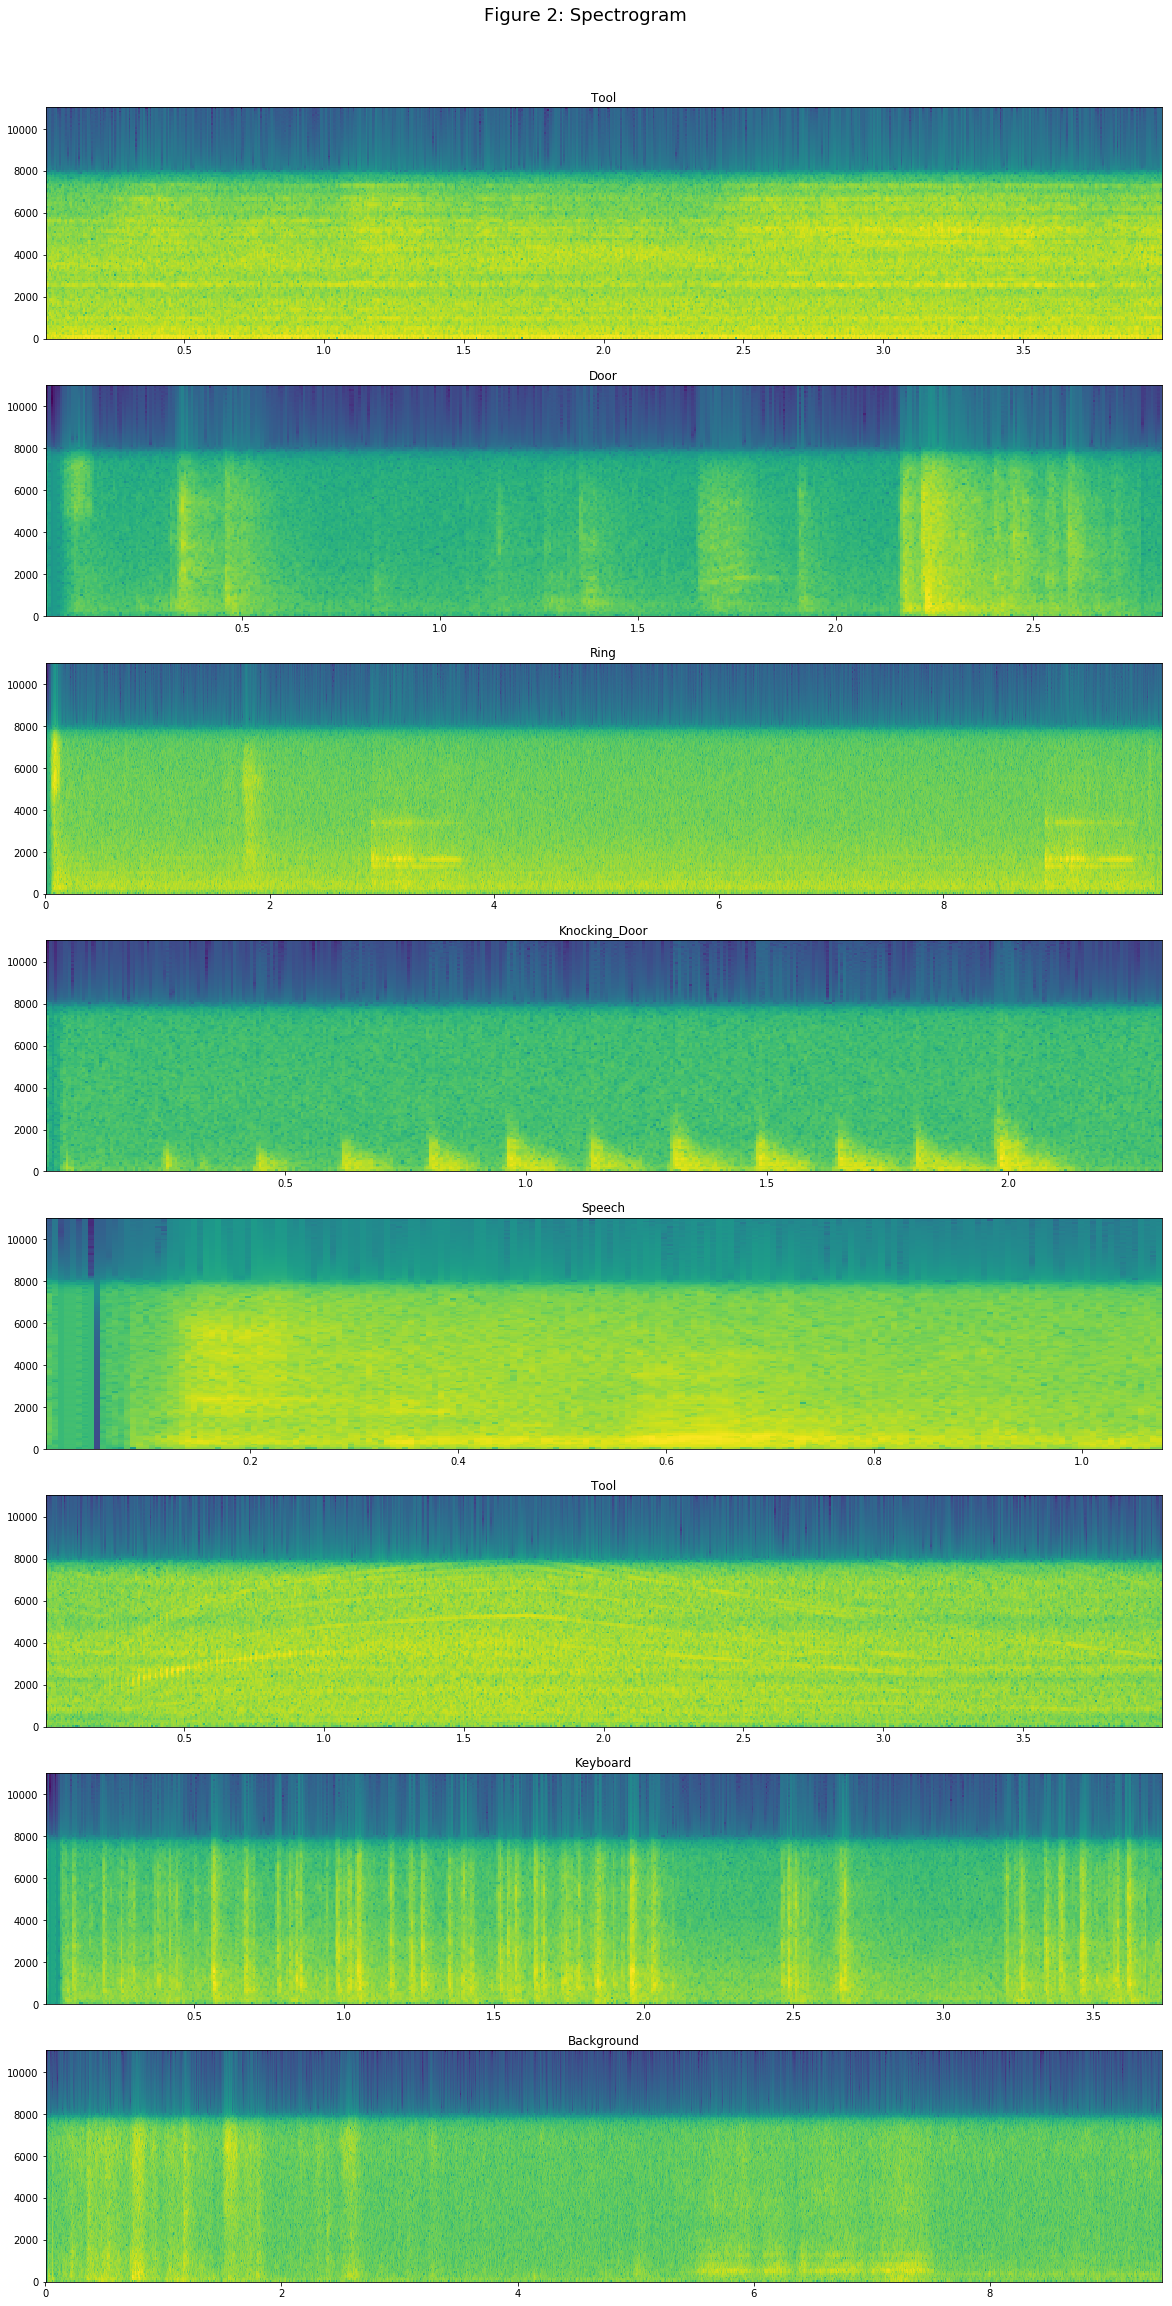

In [126]:
plot_specgram(raw_sounds=load_sound_files(['tool_0353.wav', 'door_0007.wav', 'ring_0001.wav', 'knocking_door_0053.wav', 'speech_0016.wav', 'tool_1640.wav',
                   'keyboard_0043.wav', 'background_0001.wav']), sound_names=['tool','door','ring', 'knocking_door', 'speech', 'tool', 'keyboard', 'background'])

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7221: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


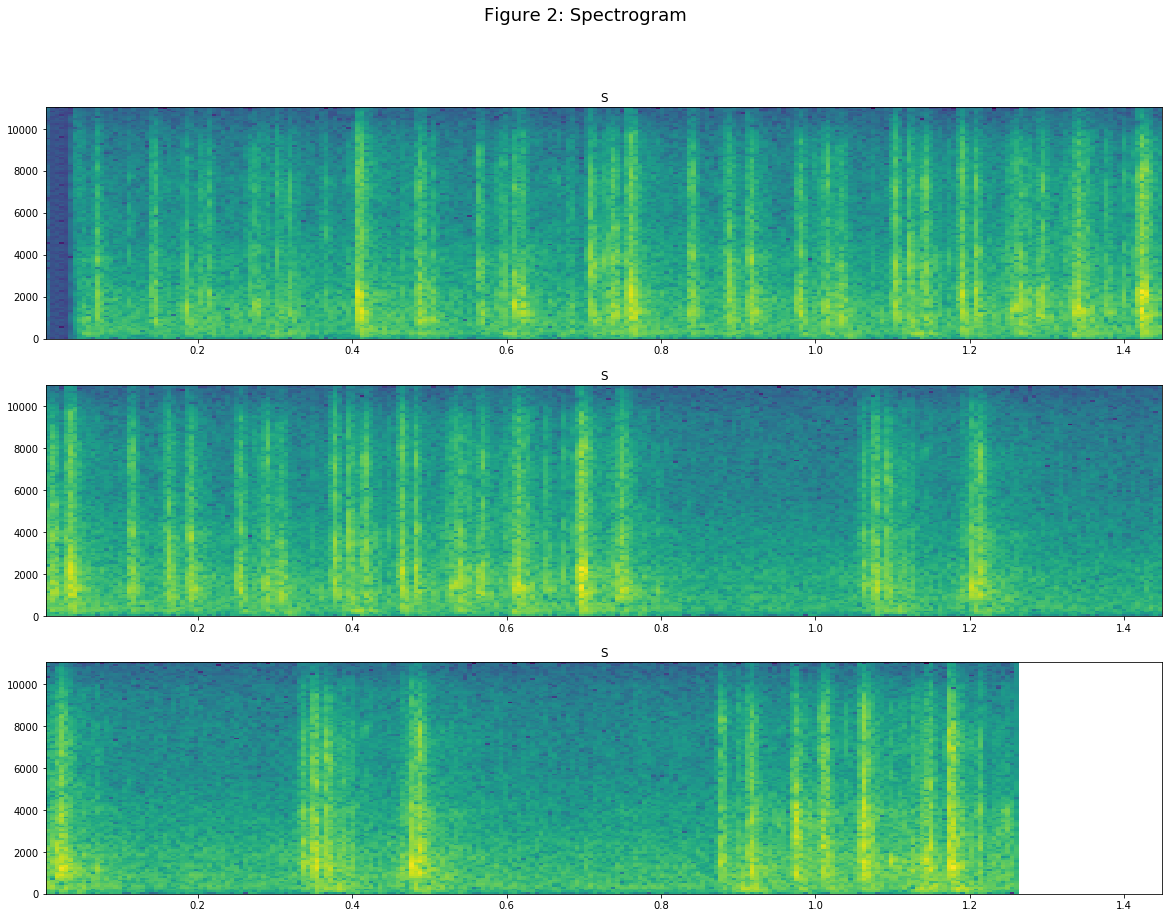

In [128]:
plot_specgram(raw_sounds=frames[:8], sound_names=S[:8])

In [94]:
S=['s']*551

In [99]:
meta.loc[10000,'f_name']

'tool_0353.wav'